<img style="float: right;" src="https://www.mcgill.ca/newsroom/files/newsroom/channels/image/thaw_slump_cluster.jpg" width=400 />

<font face="Rage" size=10 color='#d39aed'> Cryospheric hazard susceptibility with pyGAM <font>  <br>
<font size=6> [Letizia Elia](https://www.unibo.it/sitoweb/letizia.elia2), Department of Physics and Astronomy, University of Bologna <font>  <br>
<font size=6> 2022-11-30 <font>

<!-- <div></div>*/ -->


In [119]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pygam
from pygam import LogisticGAM, s, f
from sklearn.metrics import roc_auc_score
import sklearn
import pickle
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import os
from statistics import median
from sklearn.metrics import confusion_matrix
from joblib import Parallel, delayed
from copy import copy, deepcopy
import geopandas as gpd
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
import matplotlib.patches as mpatches
from geocube.api.core import make_geocube
# import random
# from colorsys import hls_to_rgb
#
pd.options.mode.chained_assignment = None

# Folders and filenames

In [69]:
folder_results_4maps = os.getcwd()+'/Results_4maps'

In [70]:
folder_plot = os.getcwd()+'/Plot'

In [71]:
folder_models = os.getcwd()+'/Models'

In [72]:
folder_original_data = os.getcwd()+'/Original_Dataset'

In [73]:
folder_var_selection = os.getcwd()+'/Var_selection'

In [74]:
filename_original_data = 'df_ald_rts.txt'

In [75]:
names_cat_var = ['GEO']  # categorical variables
names_cyc_var = ['ASP']  # cyclic variables

# Upload data & preprocessing

In [76]:
df_tot = pd.read_csv(folder_original_data+'/'+filename_original_data,
                     header=0, sep='\t', quoting=csv.QUOTE_ALL)
# print(df.head())

In [77]:
cov_list = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
            'ASP', 'TDD', 'SNOWC']

## GEO category: string to number

In [78]:
df_tot['GEO'] = pd.Categorical(df_tot['GROUP_NAME']).codes

In [81]:
df_tot.GEO[(df_tot.SlideArea > 0) & (df_tot.GEO == -1)] = int(np.ceil(df_tot.GEO.mean()))

In [82]:
df_tot['GEO'] = df_tot['GEO'].fillna(-1)

Geology names list:

In [ ]:
for i in np.sort(df_tot.GEO.unique()):
    print(i, df_tot.GROUP_NAME[df_tot.GEO == i].iloc[0])

## Drop nan

In [84]:
df_tot.dropna(inplace=True)

In [85]:
df_tot.reset_index(inplace=True)

## Select one of the two hazards to be modeled:

In [94]:
hazard = 'rts'

In [95]:
df = df_tot[['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
             'ASP', 'TDD', 'SNOWC', hazard]]

In [96]:
df.rename(columns={"rts": "PresAbs"}, inplace=True)

## Corrplot

In [97]:
cov_list_numeric = cov_list.copy()
cov_list_numeric = [e for e in cov_list_numeric if e not in names_cat_var]  # remove the categorical variable

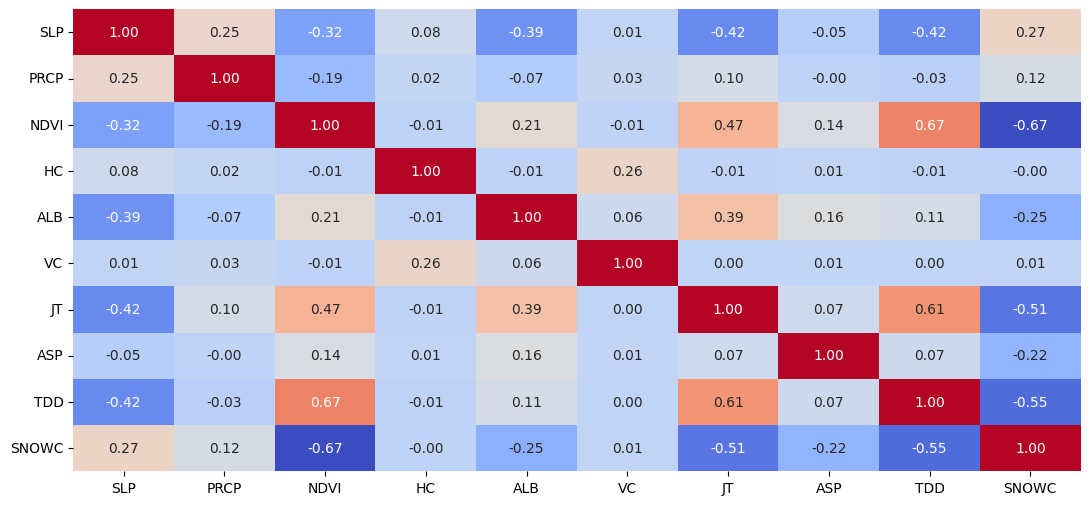

In [98]:
# ----- built-in pandas -----
# corr = df[GAM_sel].corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

fig, ax = plt.subplots(figsize=(13, 6))
corr = df[cov_list_numeric].corr()
sns.heatmap(df[cov_list_numeric].corr(method='pearson'), annot=True, fmt='.2f',
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig(folder_plot+'/Correlation_plot.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

## Variable selection

In [29]:
spl = 10

### Functions

In [ ]:
def new_splines_dtypes(var_list):
    splines = pygam.terms.TermList()
    dtypes = []

    if not not var_list:
        for idx, var in enumerate(var_list):
            if var in names_cat_var:
                splines._terms.append(f(idx))
                dtypes.append('categorical')
            elif var in names_cyc_var:
                splines._terms.append(s(idx, n_splines=spl, basis='cp'))
                dtypes.append('numerical')
            else:
                splines._terms.append(s(idx, n_splines=spl))
                dtypes.append('numerical')
    return splines, dtypes

In [ ]:
def append_splines_dtypes(splines, dtypes, var):
    splines_aux = deepcopy(splines)
    idx = len(splines)
    if var in names_cat_var:
        splines_aux._terms.append(f(idx))
        dtypes_aux = dtypes + ['categorical']
    elif var in names_cyc_var:
        splines_aux._terms.append(s(idx, n_splines=spl, basis='cp'))
        dtypes_aux = dtypes + ['numerical']
    else:
        splines_aux._terms.append(s(idx, n_splines=spl))
        dtypes_aux = dtypes + ['numerical']
    return splines_aux, dtypes_aux

### Variable selection, pyGAM

In [41]:
sub_var = np.copy(cov_list)

In [65]:
add_var = []

In [ ]:
aic_list = []
auc_list = []
iteration = 0

while not not sub_var:
    aic = []
    auc = []

    splines, dtypes = new_splines_dtypes(add_var)

    for var in sub_var:
        splines2, dtypes2 = append_splines_dtypes(splines, dtypes, var)

        X = df[add_var+[var]].to_numpy()
        y = df.PresAbs.to_numpy()

        gam = LogisticGAM(splines2, dtype=dtypes2)
        gam.gridsearch(X, y)

        iteration = iteration + 1
        filename = folder_var_selection + '/gam_'+hazard+'_'+str(iteration)+'.pkl'
        with open(filename, 'wb') as filez:
            pickle.dump(gam, filez)

        aic.append(gam.statistics_['AIC'])
        prob = gam.predict_proba(X)
        auc.append(roc_auc_score(y, prob))

    ind = aic.index(np.min(aic))
    aic_list.append(aic[ind])
    auc_list.append(auc[ind])
    add_var.append(sub_var[ind])
    sub_var.pop(ind)

GAM_sel = add_var

# results: GAM_sel, aic_list, auc_list

In [38]:
with open(folder_var_selection+"/VS_list_aic_"+hazard+".txt", "w") as txt_file:
    for i in range(0, len(cov_list)):
        txt_file.write(cov_list[i]+' '+str(aic_list[i])+"\n")

In [39]:
with open(folder_var_selection+"/VS_list_auc_"+hazard+".txt", "w") as txt_file:
    for i in range(0, len(cov_list)):
        txt_file.write(cov_list[i]+' '+str(auc_list[i])+"\n")

### Plot

In [66]:
if hazard == 'rts':
    aic_color = 'darkgreen'
    auc_color = 'yellowgreen'
else:
    aic_color = 'indigo'
    auc_color = 'violet'

In [67]:
df_aic = pd.read_csv(folder_var_selection+'/'+'VS_list_aic_'+hazard+'.txt',
                     header=None, delim_whitespace=True, quoting=csv.QUOTE_ALL)
df_auc = pd.read_csv(folder_var_selection+'/'+'VS_list_auc_'+hazard+'.txt',
                     header=None, delim_whitespace=True, quoting=csv.QUOTE_ALL)

In [68]:
add_var = df_aic[0]
aic_list = df_aic[1]
auc_list = df_auc[1]

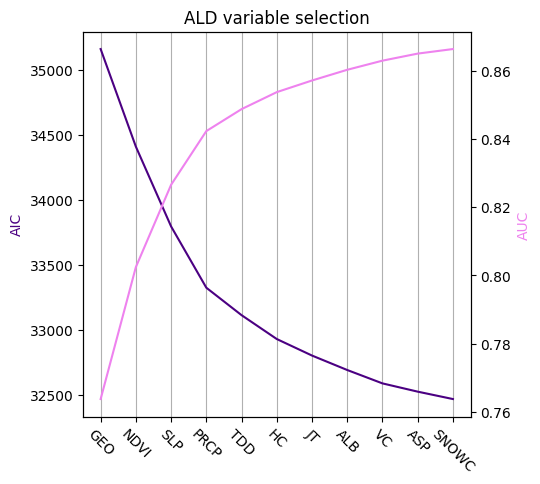

In [70]:
fig, ax1 = plt.subplots(figsize=(5, 5))

x = np.arange(1, len(add_var)+1)

y1 = aic_list
y2 = auc_list

ax2 = ax1.twinx()
ax1.plot(x, y1, aic_color)
ax2.plot(x, y2, auc_color)

ax1.set_xlabel('')
ax1.set_ylabel('AIC', color=aic_color)
ax2.set_ylabel('AUC', color=auc_color)

ax1.grid(axis='x')

ax1.set_xticks(np.arange(1, len(add_var)+1))
ax1.set_xticklabels(add_var, rotation=-45)

plt.title(hazard.upper()+' variable selection')
plt.savefig(folder_plot+'/VS_aic_auc_'+hazard+'.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

# GAM

Select one of the two hazards to be modeled:

In [54]:
hazard = 'rts'

In [55]:
df = df_tot[['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
             'ASP', 'TDD', 'SNOWC', hazard]]

In [56]:
df.rename(columns={"rts": "PresAbs"}, inplace=True)

GAM_sel is the covariates list resulting from the variable selection

In [172]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]',
             '[°]', '[# days]', '[-]']
    spl = 10
    splines = (f(0)+s(1, n_splines=spl)+s(2, n_splines=spl)+
               s(3, n_splines=spl)+s(4, n_splines=spl)+s(5, n_splines=spl)+
               s(6, n_splines=spl)+s(7, n_splines=spl)+
               s(8, n_splines=spl, basis='cp')+
               s(9, n_splines=spl)+s(10, n_splines=spl))
    dtypes = ['categorical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]']
    spl = 10
    splines = (f(0)+s(1, n_splines=spl)+s(2, n_splines=spl)+
               s(3, n_splines=spl)+s(4, n_splines=spl)+s(5, n_splines=spl)+
               s(6, n_splines=spl)+s(7, n_splines=spl))
    dtypes = ['categorical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical']
else:
    print('Wrong argument')

In [173]:
gam_filename = folder_models+'/Final_training_gam_'+hazard+'.pkl'

In [174]:
lams = np.empty(len(GAM_sel))
lams.fill(0.5)

In [140]:
def gam_model(df, GAM_sel, splines, dtypes, filename, lams):
    X = df[GAM_sel].to_numpy()
    y = df.PresAbs.to_numpy()

    gam = LogisticGAM(splines, dtype=dtypes)
    gam.gridsearch(X, y, lam=lams)

    # aic = gam.statistics_['AIC']
    # prob = gam.predict_proba(X)
    # auc = roc_auc_score(y, prob)

    # save
    with open(filename, 'wb') as filez:
        pickle.dump(gam, filez)

In [141]:
gam_model(df, GAM_sel, splines, dtypes, gam_filename, lams)

100% (11 of 11) |########################| Elapsed Time: 0:09:27 Time:  0:09:27


## Plot

In [175]:
# upload model
with open(folder_models+'/Final_training_gam_'+hazard+'.pkl', 'rb') as filez:
    gam = pickle.load(filez)

X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

aic = gam.statistics_['AIC']
prob = gam.predict_proba(X)
auc = roc_auc_score(y, prob)

In [176]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
else:
    line_color = 'indigo'
    fill_color = 'violet'

In [177]:
XX = gam.generate_X_grid(term=0)
pdep, confi = gam.partial_dependence(term=0, X=XX, width=0.95)

### Plot w/o exp

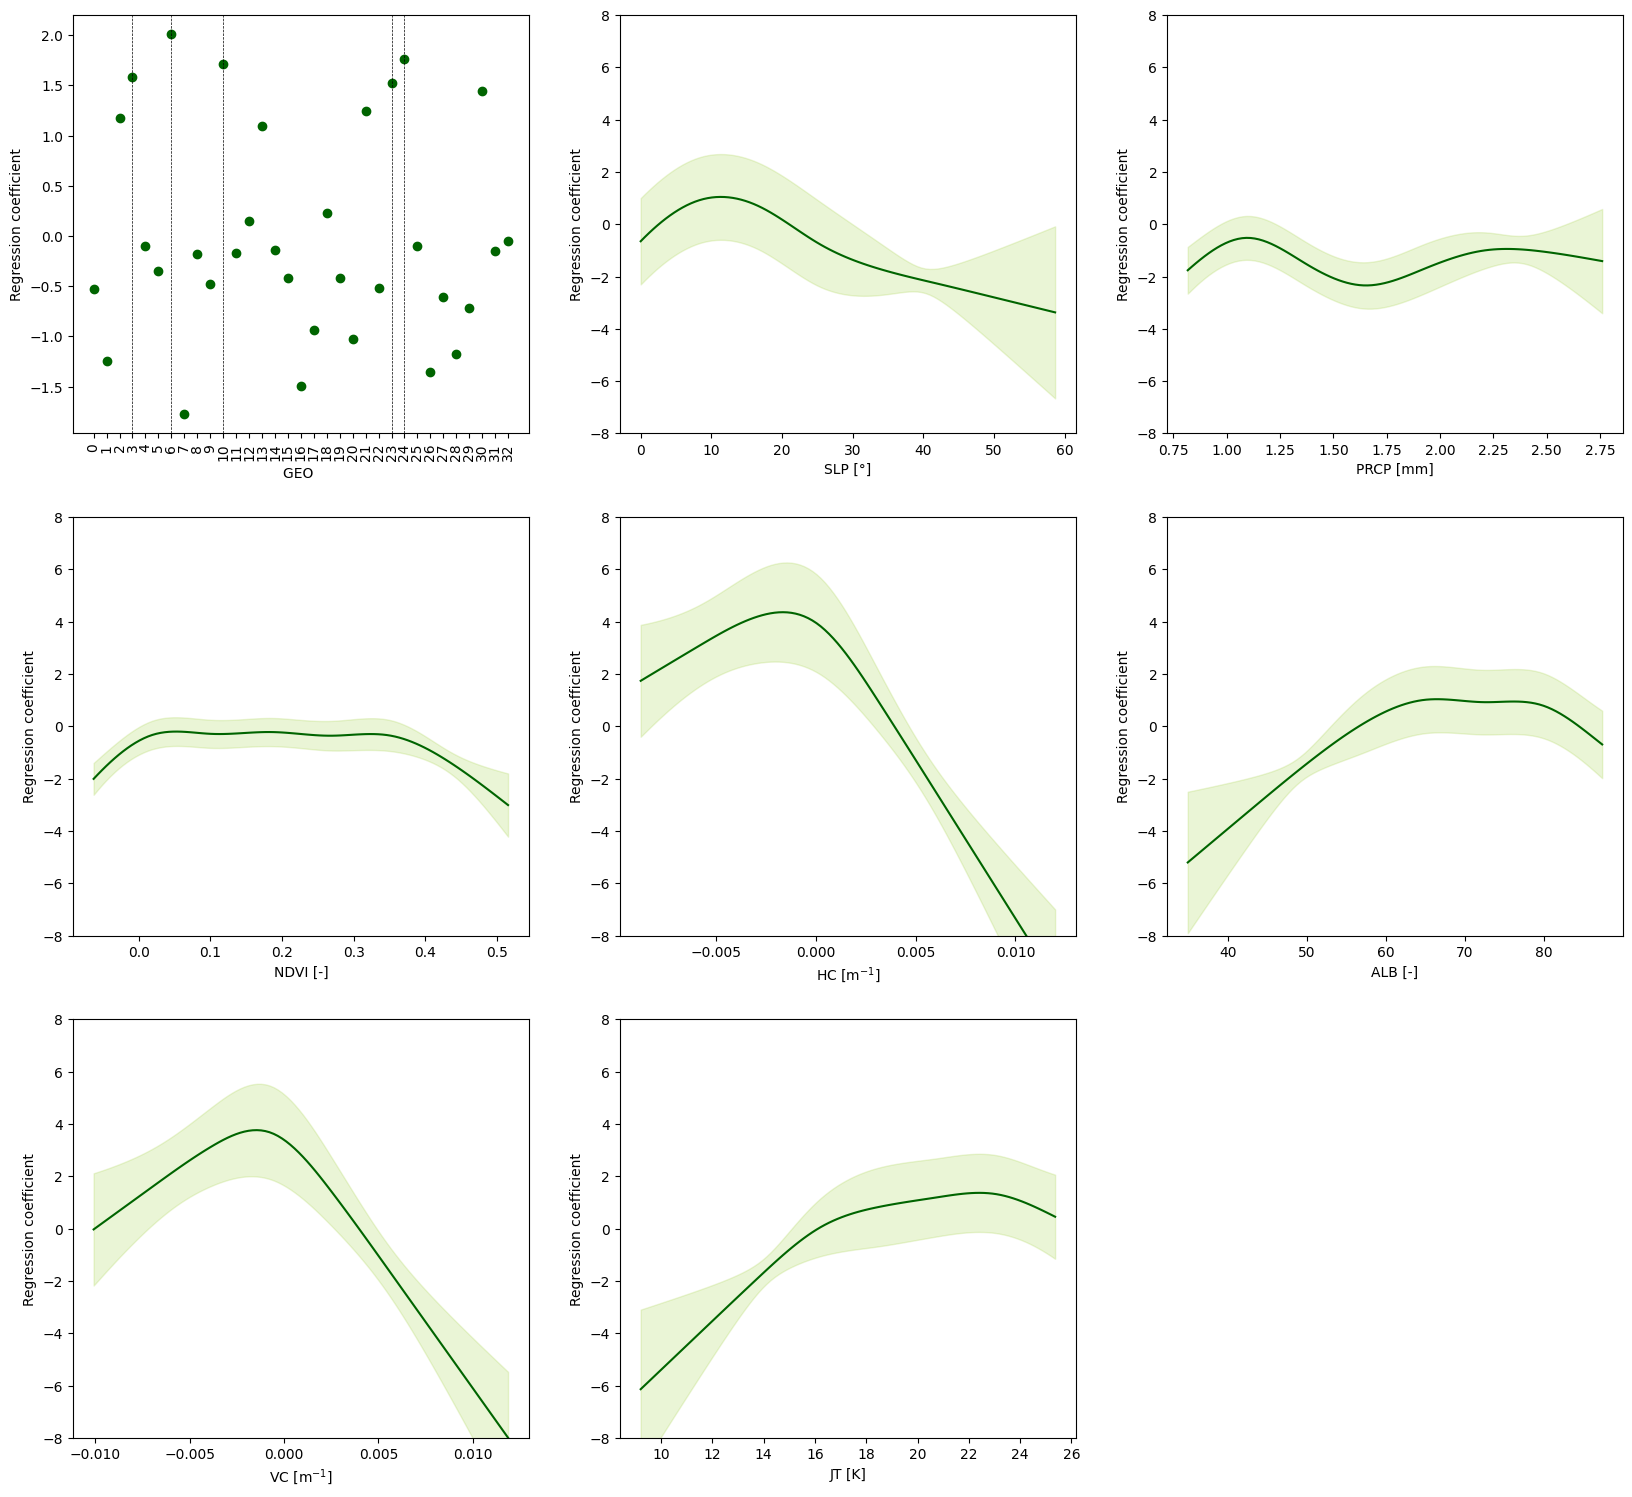

In [62]:
fig = plt.figure(figsize=(20, 25))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.subplot(4, 3, i+1)

    if isinstance(gam.terms[i], pygam.terms.FactorTerm):
        plt.plot(np.sort(df[GAM_sel[i]].unique()),
                 pdep[range(1, len(pdep), 3)], 'o', c=line_color)
        for j in pdep[range(1, len(pdep), 3)]:
            if j>1.5:
                plt.axvline(np.sort(df[GAM_sel[0]].unique())[np.where(pdep[range(1, len(pdep), 3)] == j)[0][0]],
                            color='k', linewidth=0.5, linestyle="--")
        plt.xticks(np.sort(df[GAM_sel[i]].unique()), rotation=90)
        plt.xlabel(GAM_sel[i] + ' ' + units[i])
        plt.ylabel('Regression coefficient')
        continue

    plt.plot(XX[:, term.feature], pdep, c=line_color)
    # plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.fill_between(XX[:, term.feature].ravel(), y1=confi[:,0], y2=confi[:,1], color=fill_color, alpha=0.2)

    plt.xlabel(GAM_sel[i] + ' ' + units[i])
    plt.ylabel('Regression coefficient')
    plt.ylim(-8,+8)
plt.savefig(folder_plot+'/Model_covariates_'+hazard+'.pdf', bbox_inches='tight')
plt.show()

### Plot w exp

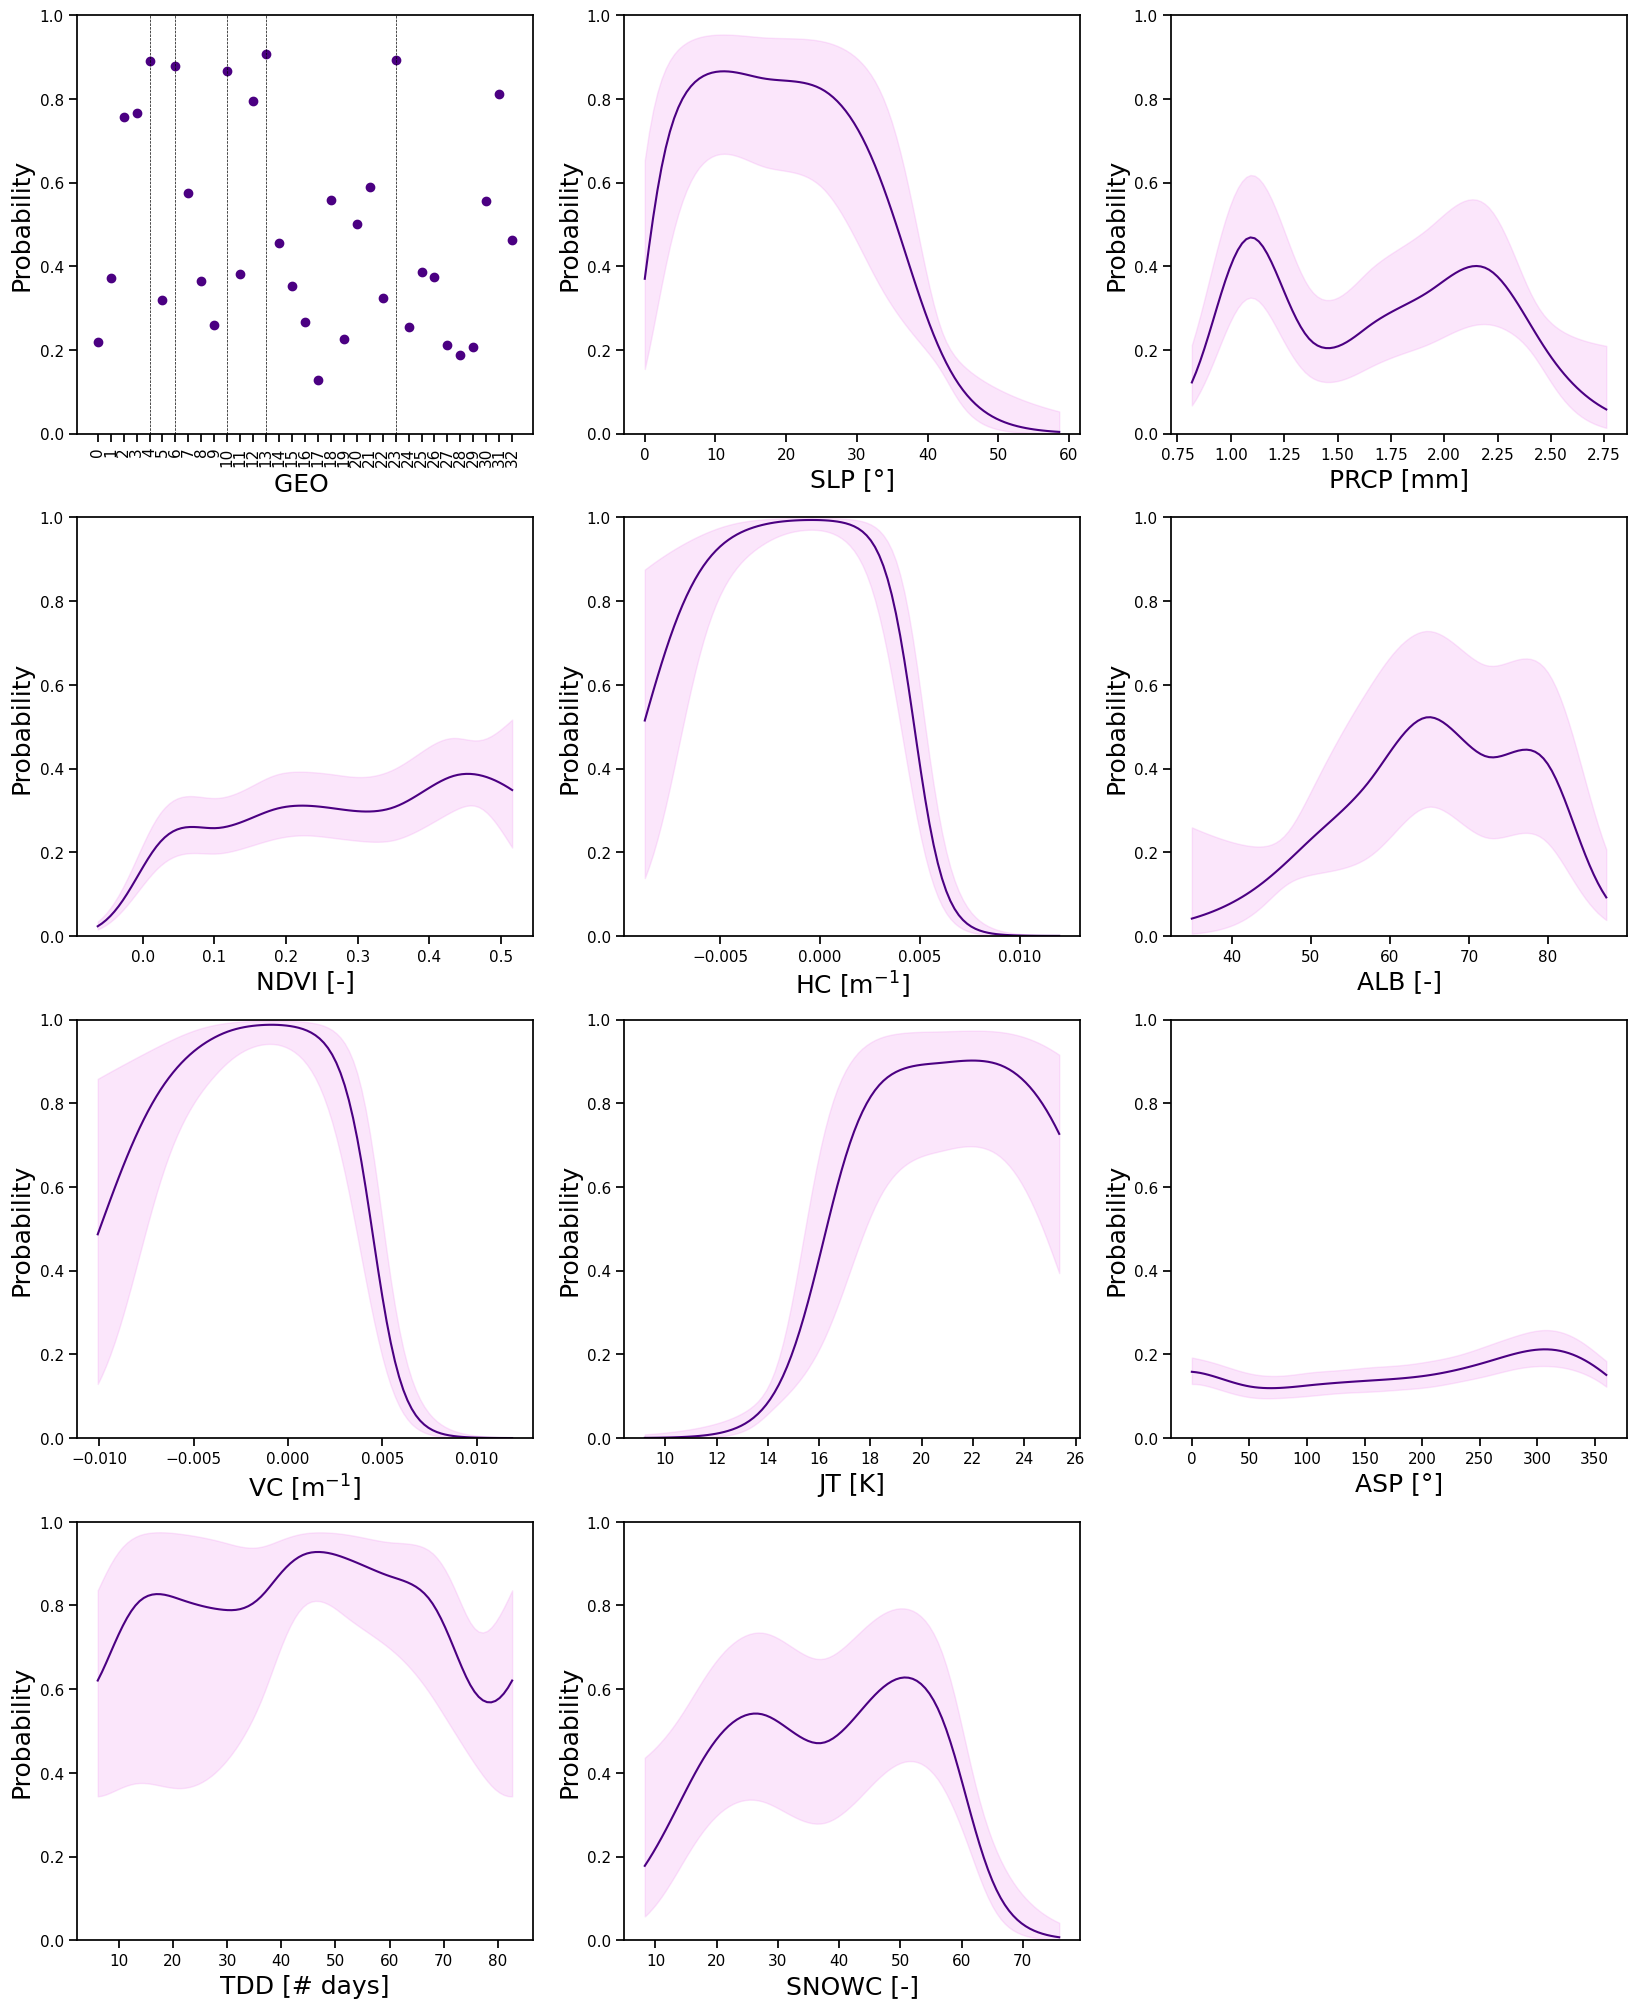

In [178]:
fig = plt.figure(figsize=(20, 25))
axis_font = {'size': '18'}
plt.rcParams.update({'font.size': 10})
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.subplot(4, 3, i+1)

    if isinstance(gam.terms[i], pygam.terms.FactorTerm):
        plt.plot(np.sort(df[GAM_sel[i]].unique()),
                 (np.exp(pdep[range(1, len(pdep), 3)])/(1+np.exp(pdep[range(1, len(pdep), 3)]))),
                 'o', c=line_color)
        for j in pdep[range(1, len(pdep), 3)]:
            if j > 1.5:
                plt.axvline(np.sort(df[GAM_sel[0]].unique())[np.where(pdep[range(1, len(pdep), 3)] == j)[0][0]],
                            color='k', linewidth=0.5, linestyle="--")
        plt.xticks(np.sort(df[GAM_sel[i]].unique()), rotation=90)
        plt.xlabel(GAM_sel[i] + ' ' + units[i], **axis_font)
        plt.ylabel('Probability', **axis_font)
        plt.ylim(0, 1)
        continue

    plt.plot(XX[:, term.feature], (np.exp(pdep)/(1+np.exp(pdep))), c=line_color)
    # plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.fill_between(XX[:, term.feature].ravel(),
                     y1=(np.exp(confi[:, 0])/(1+np.exp(confi[:, 0]))),
                     y2=(np.exp(confi[:, 1])/(1+np.exp(confi[:, 1]))),
                     color=fill_color, alpha=0.2)

    plt.xlabel(GAM_sel[i] + ' ' + units[i], **axis_font)
    plt.ylabel('Probability', **axis_font)
    plt.ylim(0, 1)

plt.savefig(folder_plot+'/Model_covariates_'+hazard+'_exp.png', bbox_inches='tight')
plt.show()

# RCV

Select one of the two hazards to be modeled:

In [54]:
hazard = 'rts'

In [55]:
df = df_tot[['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
             'ASP', 'TDD', 'SNOWC', hazard]]

In [56]:
df.rename(columns={"rts": "PresAbs"}, inplace=True)

In [385]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]',
             '[°]', '[# days]', '[-]']
    spl = 10
    splines = (f(0)+s(1, n_splines=spl)+s(2, n_splines=spl)+
               s(3, n_splines=spl)+s(4, n_splines=spl)+s(5, n_splines=spl)+
               s(6, n_splines=spl)+s(7, n_splines=spl)+
               s(8, n_splines=spl, basis='cp')+
               s(9, n_splines=spl)+s(10, n_splines=spl))
    dtypes = ['categorical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]']
    spl = 10
    splines = (f(0)+s(1, n_splines=spl)+s(2, n_splines=spl)+
               s(3, n_splines=spl)+s(4, n_splines=spl)+s(5, n_splines=spl)+
               s(6, n_splines=spl)+s(7, n_splines=spl))
    dtypes = ['categorical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical']
else:
    print('Wrong argument')

## Training

In [386]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [387]:
lams = np.empty(len(GAM_sel))
lams.fill(0.5)

In [388]:
def gam_model_cv(X, y, splines, dtypes, lams, n_fold):
    gam = LogisticGAM(splines, dtype=dtypes)
    gam.gridsearch(X, y, lam=lams)

    # aic = gam.statistics_['AIC']
    # prob = gam.predict_proba(X)
    # auc = roc_auc_score(y, prob)

    # save
    filename = folder_models+'/cv_fold_'+hazard+'_'+str(n_fold)+'.pkl'
    with open(filename, 'wb') as filez:
        pickle.dump(gam, filez)

### 10 Fold CV

In [389]:
kf = KFold(n_splits=10, shuffle=True, random_state=100)

In [390]:
folds = list(kf.split(X))

### Training GAM cv

In [70]:
def cv_func(folds, n_fold):
    X_train = X[folds[n_fold][0]] # , X[folds[n_fold][1]]
    y_train = y[folds[n_fold][0]] # , y[folds[n_fold][1]]
    gam_model_cv(X_train, y_train, splines, dtypes, lams, n_fold)

In [71]:
Parallel(n_jobs=5, verbose=2)(delayed(cv_func)(folds, n_fold) for n_fold in range(0, 10))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
100% (8 of 8) |##########################| Elapsed Time: 0:09:50 Time:  0:09:50
100% (8 of 8) |##########################| Elapsed Time: 0:10:39 Time:  0:10:39
100% (8 of 8) |##########################| Elapsed Time: 0:10:48 Time:  0:10:48
100% (8 of 8) |##########################| Elapsed Time: 0:10:56 Time:  0:10:56
100% (8 of 8) |##########################| Elapsed Time: 0:11:32 Time:  0:11:32
100% (8 of 8) |##########################| Elapsed Time: 0:08:46 Time:  0:08:46
100% (8 of 8) |##########################| Elapsed Time: 0:08:58 Time:  0:08:58
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed: 20.0min remaining:  8.6min
100% (8 of 8) |##########################| Elapsed Time: 0:10:05 Time:  0:10:05
100% (8 of 8) |##########################| Elapsed Time: 0:10:08 Time:  0:10:08
100% (8 of 8) |##########################| Elapsed Time: 0:10:34 Time:  0:10:34
[Parallel(n_jobs=5)]: Done  10 out of  10 | e

[None, None, None, None, None, None, None, None, None, None]

## Plot

In [391]:
rcv_auc = []
rcv_f1 = []
rcv_ck = []

In [392]:
TP_obsP_rcv = []
TN_obsN_rcv = []

In [393]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
else:
    line_color = 'indigo'
    fill_color = 'violet'

### Plot mean ROC curve with CI

In [92]:
mean_fpr = np.linspace(0, 1, 100)
tprs = []
std_tprs = []

k = -1
for train_index, test_index in kf.split(X):
    k += 1
    with open(folder_models+'/cv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)

    tprs.append(np.interp(mean_fpr, fpr, tpr))

In [95]:
mean_tpr = np.mean(tprs, axis=0)
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)

std_tpr = 1*np.std(tprs, axis=0)
tpr_upper = np.clip(mean_tpr+1*std_tpr, 0, 1)
tpr_lower = np.clip(mean_tpr-1*std_tpr, 0, 1)

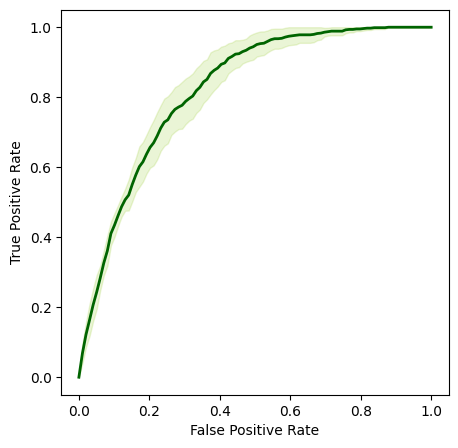

In [96]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(mean_fpr, mean_tpr, color=line_color,
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.fill_between(mean_fpr,
                 y1=tpr_upper,
                 y2=tpr_lower,
                 color=fill_color, alpha=0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.savefig(folder_plot+'/Random_CV_ROC_'+hazard+'_mean.pdf', bbox_inches='tight')
plt.show()

### Boxplot

In [394]:
mean_fpr = np.linspace(0, 1, 100)
tprs = []
std_tprs = []

rcv_auc = []
rcv_f1 = []
rcv_ck = []

k = -1
for train_index, test_index in kf.split(X):
    k += 1
    with open(folder_models+'/cv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)

    tprs.append(np.interp(mean_fpr, fpr, tpr))

    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    rcv_auc.append(auc)

    prob_median = median(prob)
    suscept = copy(prob)
    suscept[prob > prob_median] = 1
    suscept[prob <= prob_median] = 0

    rcv_f1.append(f1_score(y_test, suscept))
    rcv_ck.append(cohen_kappa_score(y_test, suscept))

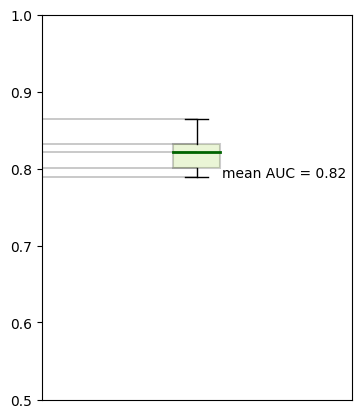

In [395]:
fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(111)
boxprops = dict(color="black", linewidth=1.5)
medianprops = dict(color=line_color, linewidth=2)
bp = ax.boxplot(rcv_auc, showfliers=True,
                boxprops=boxprops, medianprops=medianprops, patch_artist=True)
bp['boxes'][0].set_facecolor(fill_color)
bp['boxes'][0].set_alpha(0.2)
quantiles = np.quantile(rcv_auc, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.hlines(quantiles, [0.5] * quantiles.size, [1] * quantiles.size,
          color='k', ls='-', lw=0.3, zorder=0)
ax.set_xticks([])
ax.set_ylim(0.5,1)
plt.text(1.08, bp['whiskers'][0].get_ydata()[1], 'mean AUC = '+str(round(np.mean(rcv_auc), 2)))
plt.savefig(folder_plot+'/Random_CV_boxplot_'+hazard+'.pdf', bbox_inches='tight')
plt.show()

# SCV

Select one of the two hazards to be modeled:

In [54]:
hazard = 'rts'

In [55]:
df = df_tot[['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
             'ASP', 'TDD', 'SNOWC', hazard]]

In [56]:
df.rename(columns={"rts": "PresAbs"}, inplace=True)

In [42]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]',
             '[°]', '[# days]', '[-]']
    spl = 10
    splines = (f(0)+s(1, n_splines=spl)+s(2, n_splines=spl)+
               s(3, n_splines=spl)+s(4, n_splines=spl)+s(5, n_splines=spl)+
               s(6, n_splines=spl)+s(7, n_splines=spl)+
               s(8, n_splines=spl, basis='cp')+
               s(9, n_splines=spl)+s(10, n_splines=spl))
    dtypes = ['categorical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]']
    spl = 10
    splines = (f(0)+s(1, n_splines=spl)+s(2, n_splines=spl)+
               s(3, n_splines=spl)+s(4, n_splines=spl)+s(5, n_splines=spl)+
               s(6, n_splines=spl)+s(7, n_splines=spl))
    dtypes = ['categorical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical',
              'numerical', 'numerical']
else:
    print('Wrong argument')

## Training

In [68]:
coords = np.stack((df.X, df.Y), axis=1)

In [69]:
if hazard == 'rts':
    kmeans = KMeans(n_clusters=11, random_state=10, n_init=2, max_iter=10).fit(coords)
    kmeans.labels_[np.where(kmeans.labels_ == 7)] = 2
else:
    kmeans = KMeans(n_clusters=10, random_state=10, n_init=2, max_iter=10).fit(coords)

In [70]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [71]:
lams = np.empty(len(GAM_sel))
lams.fill(0.5)

In [72]:
def gam_model_spcv(X, y, splines, dtypes, lams, counter):
    gam = LogisticGAM(splines, dtype=dtypes)
    gam.gridsearch(X, y, lam=lams)

    filename = folder_models+'/spcv_fold_'+hazard+'_'+str(counter)+'.pkl'
    with open(filename, 'wb') as filez:
        pickle.dump(gam, filez)

### 10 Fold SPCV

In [359]:
y_ind = np.where(df.PresAbs.to_numpy() == 1)

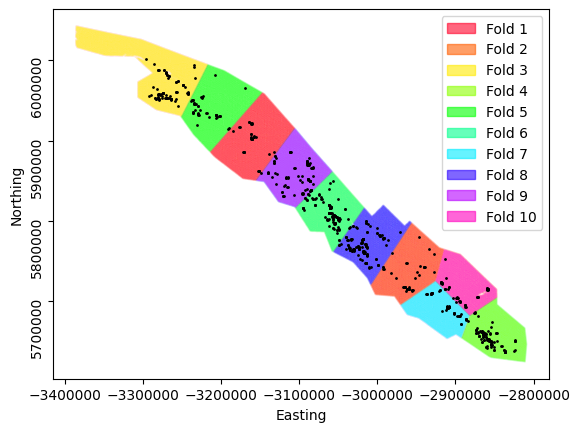

In [286]:
plt.figure()
ax = plt.gca()
cmap = plt.get_cmap("gist_rainbow")
plt.scatter(df.X, df.Y, c=cmap(kmeans.labels_/10), alpha=0.01, s=0.1)
plt.scatter(df.X.iloc[y_ind], df.Y.iloc[y_ind], c='k', s=1)
#
red_patch = []
for i in range(len(cmap(np.unique(kmeans.labels_)/10))):
    red_patch.append(mpatches.Patch(color=cmap(np.unique(kmeans.labels_)/10)[i],
                                    alpha=0.6, label='Fold '+str(i+1)))

plt.legend(handles=red_patch)
ax.ticklabel_format(useOffset=False, style='plain')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.yticks(rotation=90)
plt.savefig(folder_plot+'/Cluster_spcv_'+hazard+'.png', bbox_inches='tight')
plt.show()

### Training GAM spcv

In [ ]:
def spcv_func(fold):
    X_train = X[np.where(kmeans.labels_ != fold)]
    y_train = y[np.where(kmeans.labels_ != fold)]
    gam_model_spcv(X_train, y_train, splines, dtypes, lams, fold)

In [ ]:
Parallel(n_jobs=3, verbose=4)(delayed(spcv_func)(fold) for fold in [0, 1, 2, 3, 4, 5, 6, 8, 9, 10])

## Plot

In [230]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [231]:
scv_auc = []
TP_obsP_scv = []
TN_obsN_scv = []

In [232]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
else:
    line_color = 'indigo'
    fill_color = 'violet'

### Plot mean ROC curve with CI

In [ ]:
mean_fpr = np.linspace(0,1,100)
tprs = []
std_tprs = []

for k in np.unique(kmeans.labels_):
    # print(k)
    with open(folder_models+'/spcv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_test = X[np.where(kmeans.labels_ == k)]
    # print(len(X_test))
    y_test = y[np.where(kmeans.labels_ == k)]
    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    scv_auc.append(auc)

In [ ]:
mean_tpr = np.mean(tprs, axis=0)
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)

std_tpr = 1*np.std(tprs, axis=0)
tpr_upper = np.clip(mean_tpr+std_tpr, 0, 1)
tpr_lower = np.clip(mean_tpr-std_tpr, 0, 1)

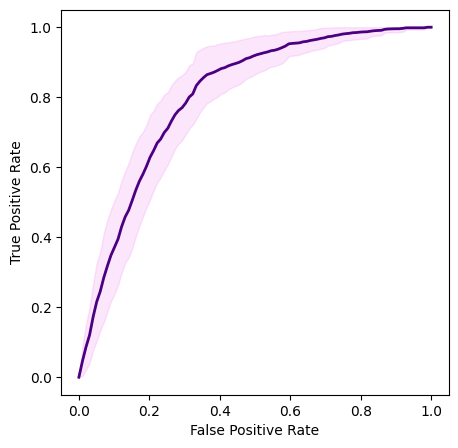

In [251]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(mean_fpr, mean_tpr, color=line_color,
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.fill_between(mean_fpr,
                 y1=tpr_upper,
                 y2=tpr_lower,
                 color=fill_color, alpha=0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.savefig(folder_plot+'/Spatial_CV_ROC_'+hazard+'_mean.pdf', bbox_inches='tight')
plt.show()

### Boxplot

In [402]:
scv_auc = []

for k in np.unique(kmeans.labels_):
    with open(folder_models+'/spcv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_test = X[np.where(kmeans.labels_ == k)]
    # print(len(X_test))
    y_test = y[np.where(kmeans.labels_ == k)]
    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)
    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    scv_auc.append(auc)

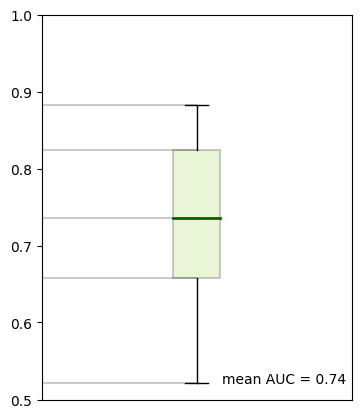

In [403]:
fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(111)
boxprops = dict(color="black", linewidth=1.5)
medianprops = dict(color=line_color, linewidth=2)
bp = ax.boxplot(scv_auc, showfliers=True,
                boxprops=boxprops, medianprops=medianprops, patch_artist=True)
bp['boxes'][0].set_facecolor(fill_color)
bp['boxes'][0].set_alpha(0.2)
quantiles = np.quantile(scv_auc, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.hlines(quantiles, [0.5] * quantiles.size, [1] * quantiles.size,
          color='k', ls='-', lw=0.3, zorder=0)
ax.set_xticks([])
ax.set_ylim(0.5,1)
plt.text(1.08, bp['whiskers'][0].get_ydata()[1], 'mean AUC = '+str(round(np.mean(scv_auc), 2)))
plt.savefig(folder_plot+'/Spatial_CV_boxplot_'+hazard+'.pdf', bbox_inches='tight')
plt.show()

# Susceptibility

Select one of the two hazards to be modeled:

In [102]:
hazard = 'rts'

In [103]:
df = df_tot[['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
             'ASP', 'TDD', 'SNOWC', hazard]]

In [104]:
df.rename(columns={"rts": "PresAbs"}, inplace=True)

In [105]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]',
             '[°]', '[# days]', '[-]']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
    units = ['', '[°]', '[mm]', '[-]', r'$[\rm m^{-1}]$', '[-]',
             r'$[\rm m^{-1}]$', '[K]']
else:
    print('Wrong argument')

In [106]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [107]:
gam_filename = folder_models+'/Final_training_gam_'+hazard+'.pkl'
with open(gam_filename, 'rb') as filez:
    gam = pickle.load(filez)

In [108]:
prob = gam.predict_proba(X)

In [109]:
prob = gam.predict_proba(X)
prob_median = median(prob)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, prob)
idx = np.argmax(tpr - fpr)  # x YOUDEN INDEX
auc = sklearn.metrics.roc_auc_score(y, prob)
prob_median = median(prob)
suscept01 = copy(prob)
suscept01[prob > thresholds[idx]] = 1
suscept01[prob <= thresholds[idx]] = 0
f1_tot = f1_score(y, suscept01)
ck_tot = cohen_kappa_score(y, suscept01)

In [112]:
df_suscept_continuous = df_tot[['X', 'Y']].copy()

In [113]:
df_suscept_continuous['suscept'] = prob

In [114]:
df_suscept_continuous['y'] = y

## ROC curve fit

In [110]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
else:
    line_color = 'indigo'
    fill_color = 'violet'

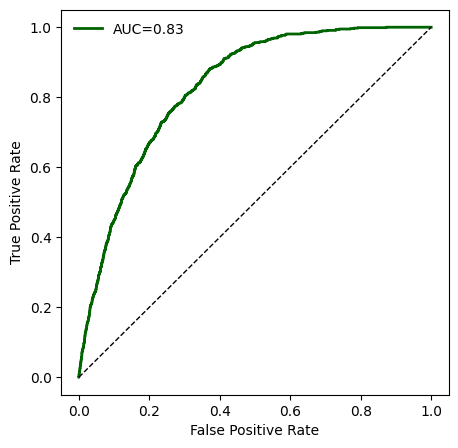

In [111]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(fpr, tpr, color=line_color, linewidth=2,
        label=f'AUC={round(auc, 2)}')
ax.plot([0, 1], [0, 1],  linestyle="--", linewidth=1, color='k')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(frameon=False)
plt.savefig(folder_plot+'/ROC_fit_'+hazard+'.pdf', bbox_inches='tight')
plt.show()

## Boxplot

In [115]:
if hazard == 'rts':
    df_suscept_continuous['binary_string'] = 'No-RTS'
    df_suscept_continuous['binary_string'][df_suscept_continuous['y'] == 1] = 'RTS'
else:
    df_suscept_continuous['binary_string'] = 'No-ALD'
    df_suscept_continuous['binary_string'][df_suscept_continuous['y'] == 1] = 'ALD'

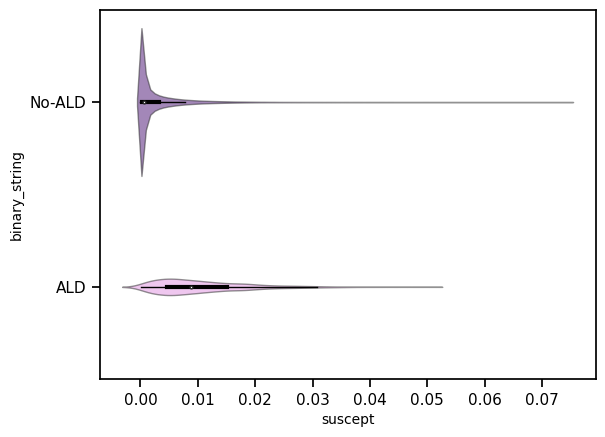

In [274]:
# BOXPLOT 0 1
fig, ax = plt.subplots()
sns.set_context('notebook')
my_pal = [line_color, fill_color]
sns.violinplot(y=df_suscept_continuous['binary_string'],
               x=df_suscept_continuous['suscept'],
               data=df_suscept_continuous,
               palette=my_pal,
               linewidth=1,
               inner='box',
               zorder=0)
ax.get_children()[4].set_alpha(0.5)
ax.get_children()[0].set_alpha(0.5)

ax.get_children()[2].set_color('k')  # <------------- changes the colour of the sticks
ax.get_children()[1].set_color('k')  # <------------- changes the colour of the box
ax.get_children()[5].set_color('k')  # <------------- changes the colour of the sticks
ax.get_children()[6].set_color('k')  # <------------- changes the colour of the box

# ax.xaxis.tick_top()
# ax.set_xticklabels(ax.get_xticks(), rotation = -45)

plt.savefig(folder_plot+"/boxplot_sushi_"+hazard+".pdf", bbox_inches='tight')

## Density function

In [291]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
    n1 = 0.000591523
    n2 = 0.001833722
    n3 = 0.003963205
    n4 = 0.01508384
    c1 = (1, 1, 204/255)
    c2 = (184/225, 214/255, 110/255)
    c3 = (101/225, 168/255, 115/255)
    c4 = (50/225, 84/255, 57/255)

else:
    line_color = 'indigo'
    fill_color = 'violet'
    n1 = 0.002817639
    n2 = 0.008734682
    n3 = 0.018314655
    n4 = 0.071849801
    c1 = (1, 1, 204/255)
    c2 = (203/225, 153/255, 224/255)
    c3 = (139/225, 113/255, 181/255)
    c4 = (73/225, 45/255, 142/255)

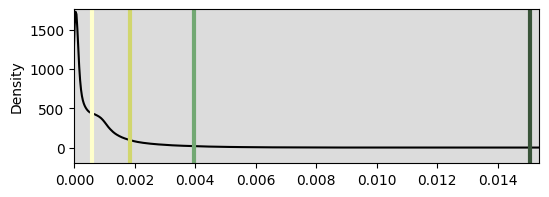

In [294]:
fig, ax = plt.subplots(figsize=(6, 2))
df_suscept_continuous.suscept.plot.density(color='black')
plt.axvline(x=n1, color=c1, linewidth=3)
plt.axvline(x=n2, color=c2, linewidth=3)
plt.axvline(x=n3, color=c3, linewidth=3)
plt.axvline(x=n4, color=c4, linewidth=3)

ax.set_facecolor('gainsboro')

# plt.title('Density plot for Speeding')
plt.xlim(0,df_suscept_continuous.suscept.max()+df_suscept_continuous.suscept.max()/50)
plt.ylim(-200,1760)
plt.savefig(folder_plot+'/density_func_'+hazard+'.pdf', bbox_inches='tight')
plt.show()

## Susceptibility raster

In [68]:
df_suscept_continuous[['X', 'Y', 'suscept']].to_csv(folder_results_4maps+'/Susceptibility_alaska_'+hazard+'.txt',
                                                    sep=' ',
                                                    header=True,
                                                    index=False,
                                                    na_rep='NaN',
                                                    float_format='%.9f')

In [50]:
gdf = gpd.GeoDataFrame(df_suscept_continuous,
                       geometry=gpd.points_from_xy(df.X, df.Y))

In [ ]:
gdf.set_crs('epsg:5070')

In [53]:
out_grid = make_geocube(vector_data=gdf,
                        measurements=["suscept"],
                        resolution=(-225, 225))  # for most crs negative comes first in resolution

In [54]:
out_grid["suscept"].rio.to_raster(folder_results_4maps+"/sushi_"+hazard+".tif")

## Confusion matrix

In [120]:
cf_matrix = confusion_matrix(y, suscept01)

In [ ]:
sns.heatmap(cf_matrix, annot=True)

In [124]:
df_confusion = df_tot[['X','Y']].copy()
df_confusion['confusion'] = np.nan
df_confusion['suscept'] = suscept01

In [125]:
df_confusion.confusion[(df_confusion.suscept == 0) & (df.PresAbs == 0)] = 1  # TN
df_confusion.confusion[(df_confusion.suscept == 0) & (df.PresAbs == 1)] = 2  # FN
df_confusion.confusion[(df_confusion.suscept == 1) & (df.PresAbs == 1)] = 3  # TP
df_confusion.confusion[(df_confusion.suscept == 1) & (df.PresAbs == 0)] = 4  # FP

In [126]:
df_confusion.to_csv(folder_results_4maps+'/Confusion_alaska'+hazard+'.txt',
                    sep=' ',
                    header=True,
                    index=False,
                    na_rep='NaN',
                    float_format='%.2f')

In [127]:
tn_fit = df_confusion.confusion.value_counts()[1]
tot_n_fit = df_confusion.confusion.value_counts()[1]+df_confusion.confusion.value_counts()[3]
tp_fit = df_confusion.confusion.value_counts()[4]
tot_p_fit = df_confusion.confusion.value_counts()[4]+df_confusion.confusion.value_counts()[2]
TP_obsP_fit = tp_fit/tot_p_fit
TN_obsN_fit = tn_fit/tot_n_fit

In [148]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
else:
    line_color = 'indigo'
    fill_color = 'violet'

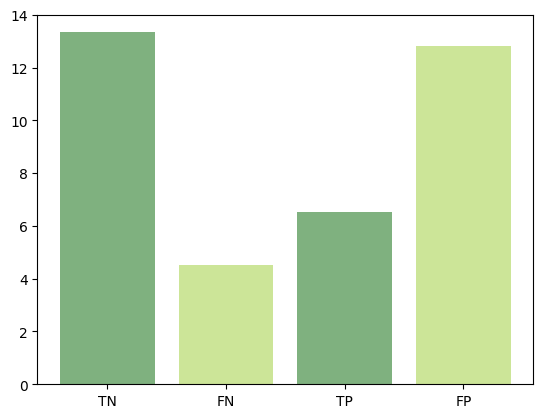

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(list(df_confusion.confusion.value_counts().index),
       np.log(df_confusion.confusion.value_counts()),
       color=[line_color, fill_color, line_color, fill_color],
       alpha=0.5)

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['TN', 'FN', 'TP', 'FP'], rotation=0)

plt.savefig(folder_plot+'/bar_'+hazard+'.pdf', bbox_inches='tight')

# Scatter plot FIT, RCV, SCV (thr = Youden index)

## Preparing data

### RTS Fit

In [102]:
hazard = 'rts'

In [103]:
df = df_tot[['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
             'ASP', 'TDD', 'SNOWC', hazard]]

In [104]:
df.rename(columns={"rts": "PresAbs"}, inplace=True)

In [68]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [69]:
X = df[GAM_sel].to_numpy()
y = df[hazard].to_numpy()

In [70]:
gam_filename = folder_models+'/Final_training_gam_'+hazard+'.pkl'
with open(gam_filename, 'rb') as filez:
    gam = pickle.load(filez)

In [71]:
prob = gam.predict_proba(X)
prob_median = median(prob)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, prob)
idx = np.argmax(tpr - fpr)
auc = sklearn.metrics.roc_auc_score(y, prob)
prob_median = median(prob)
suscept = copy(prob)
suscept[prob > thresholds[idx]] = 1
suscept[prob <= thresholds[idx]] = 0
f1_tot = f1_score(y, suscept)
ck_tot = cohen_kappa_score(y, suscept)

In [367]:
cf_matrix = confusion_matrix(y, suscept)

In [368]:
df_confusion = df[['X','Y']].copy()
df_confusion['confusion'] = np.nan
df_confusion['suscept'] = suscept

In [369]:
df_confusion.confusion[(df_confusion.suscept == 0) & (df.PresAbs == 0)] = 1 # TN
df_confusion.confusion[(df_confusion.suscept == 0) & (df.PresAbs == 1)] = 2 # FN
df_confusion.confusion[(df_confusion.suscept == 1) & (df.PresAbs == 0)] = 3 # FP
df_confusion.confusion[(df_confusion.suscept == 1) & (df.PresAbs == 1)] = 4 # TP

In [370]:
tn_fit = df_confusion.confusion.value_counts()[1]
tot_n_fit = df_confusion.confusion.value_counts()[1]+df_confusion.confusion.value_counts()[3]
tp_fit = df_confusion.confusion.value_counts()[4]
tot_p_fit = df_confusion.confusion.value_counts()[4]+df_confusion.confusion.value_counts()[2]
TP_obsP_fit_rts = tp_fit/tot_p_fit
TN_obsN_fit_rts = tn_fit/tot_n_fit

### RTS RCV

In [371]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [372]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [373]:
kf = KFold(n_splits=10, shuffle=True, random_state=100)

In [374]:
folds = list(kf.split(X))

In [375]:
rcv_auc = []
rcv_f1 = []
rcv_ck = []

In [376]:
TP_obsP_rcv_rts = []
TN_obsN_rcv_rts = []

In [377]:
k = -1
for train_index, test_index in kf.split(X):
    k += 1
    with open(folder_models+'/cv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)
    idx = np.argmax(tpr - fpr)
    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    rcv_auc.append(auc)

    prob_median = median(prob)
    suscept = copy(prob)
    suscept[prob > thresholds[idx]] = 1
    suscept[prob <= thresholds[idx]] = 0

    df_aux = pd.DataFrame()
    df_aux['suscept'] = suscept
    df_aux['confusion'] = np.nan
    df_aux['y'] = y_test
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 0)] = 1 # TN
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 1)] = 2 # FN
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 0)] = 3 # FP
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 1)] = 4 # TP
    
    try:
        fn = df_aux.confusion.value_counts()[2]
    except:
        fn = 0

    try:
        fp = df_aux.confusion.value_counts()[3]
    except:
        fp = 0

    tot_p = df_aux.confusion.value_counts()[4]+fn
    tot_n = df_aux.confusion.value_counts()[1]+fp
    tn = df_aux.confusion.value_counts()[1]
    tp = df_aux.confusion.value_counts()[4]
    TP_obsP_rcv_rts.append(tp/tot_p)
    TN_obsN_rcv_rts.append(tn/tot_n)

    rcv_f1.append(f1_score(y_test, suscept))
    rcv_ck.append(cohen_kappa_score(y_test, suscept))

### RTS SCV

In [378]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [379]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [380]:
coords = np.stack((df.X, df.Y), axis=1)

In [381]:
if hazard == 'rts':
    kmeans = KMeans(n_clusters=11, random_state=10, n_init=2, max_iter=10).fit(coords)
    kmeans.labels_[np.where(kmeans.labels_ == 7)] = 2
else:
    kmeans = KMeans(n_clusters=10, random_state=10, n_init=2, max_iter=10).fit(coords)

In [382]:
scv_auc = []
TP_obsP_scv_rts = []
TN_obsN_scv_rts = []

In [383]:
for k in np.unique(kmeans.labels_):
    with open(folder_models+'/spcv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_test = X[np.where(kmeans.labels_ == k)]
    # print(len(X_test))
    y_test = y[np.where(kmeans.labels_ == k)]
    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)
    idx = np.argmax(tpr - fpr)
    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    rcv_auc.append(auc)

    prob_median = median(prob)
    suscept = copy(prob)
    suscept[prob > thresholds[idx]] = 1
    suscept[prob <= thresholds[idx]] = 0

    df_aux = pd.DataFrame()
    df_aux['suscept'] = suscept
    df_aux['confusion'] = np.nan
    df_aux['y'] = y_test
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 0)] = 1 # TN
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 1)] = 2 # FN
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 0)] = 3 # FP
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 1)] = 4 # TP

    try:
        fn = df_aux.confusion.value_counts()[2]
    except:
        fn = 0

    try:
        fp = df_aux.confusion.value_counts()[3]
    except:
        fp = 0

    tot_p = df_aux.confusion.value_counts()[4]+fn
    tot_n = df_aux.confusion.value_counts()[1]+fp
    tn = df_aux.confusion.value_counts()[1]
    tp = df_aux.confusion.value_counts()[4]
    TP_obsP_scv_rts.append(tp/tot_p)
    TN_obsN_scv_rts.append(tn/tot_n)

### ALD Fit

In [384]:
hazard = 'ald'

In [179]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [180]:
X = df[GAM_sel].to_numpy()
y = df[hazard].to_numpy()

In [181]:
gam_filename = folder_models+'/Final_training_gam_'+hazard+'.pkl'
with open(gam_filename, 'rb') as filez:
    gam = pickle.load(filez)

In [182]:
prob = gam.predict_proba(X)
prob_median = median(prob)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, prob)
idx = np.argmax(tpr - fpr)
auc = sklearn.metrics.roc_auc_score(y, prob)
prob_median = median(prob)
suscept = copy(prob)
suscept[prob > thresholds[idx]] = 1
suscept[prob <= thresholds[idx]] = 0

f1_tot = f1_score(y, suscept)
ck_tot = cohen_kappa_score(y, suscept)

In [389]:
cf_matrix = confusion_matrix(y, suscept)

In [390]:
df_confusion = df[['X','Y']].copy()
df_confusion['confusion'] = np.nan
df_confusion['suscept'] = suscept

In [391]:
df_confusion.confusion[(df_confusion.suscept == 0) & (df.PresAbs == 0)] = 1 # TN
df_confusion.confusion[(df_confusion.suscept == 0) & (df.PresAbs == 1)] = 2 # FN
df_confusion.confusion[(df_confusion.suscept == 1) & (df.PresAbs == 0)] = 3 # FP
df_confusion.confusion[(df_confusion.suscept == 1) & (df.PresAbs == 1)] = 4 # TP

In [392]:
tn_fit = df_confusion.confusion.value_counts()[1]
tot_n_fit = df_confusion.confusion.value_counts()[1]+df_confusion.confusion.value_counts()[3]
tp_fit = df_confusion.confusion.value_counts()[4]
tot_p_fit = df_confusion.confusion.value_counts()[4]+df_confusion.confusion.value_counts()[2]
TP_obsP_fit_ald = tp_fit/tot_p_fit
TN_obsN_fit_ald = tn_fit/tot_n_fit

### ALD RCV

In [393]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [394]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [395]:
kf = KFold(n_splits=10, shuffle=True, random_state=100)

In [396]:
folds = list(kf.split(X))

In [397]:
rcv_auc = []
rcv_f1 = []
rcv_ck = []

In [398]:
TP_obsP_rcv_ald = []
TN_obsN_rcv_ald = []

In [399]:
k = -1
for train_index, test_index in kf.split(X):
    k += 1
    with open(folder_models+'/cv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)
    idx = np.argmax(tpr - fpr)
    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    rcv_auc.append(auc)

    prob_median = median(prob)
    suscept = copy(prob)
    suscept[prob > thresholds[idx]] = 1
    suscept[prob <= thresholds[idx]] = 0

    df_aux = pd.DataFrame()
    df_aux['suscept'] = suscept
    df_aux['confusion'] = np.nan
    df_aux['y'] = y_test
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 0)] = 1 # TN
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 1)] = 2 # FN
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 0)] = 3 # FP
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 1)] = 4 # TP

    try:
        fn = df_aux.confusion.value_counts()[2]
    except:
        fn = 0

    try:
        fp = df_aux.confusion.value_counts()[3]
    except:
        fp = 0

    tot_p = df_aux.confusion.value_counts()[4]+fn
    tot_n = df_aux.confusion.value_counts()[1]+fp
    tn = df_aux.confusion.value_counts()[1]
    tp = df_aux.confusion.value_counts()[4]
    TP_obsP_rcv_ald.append(tp/tot_p)
    TN_obsN_rcv_ald.append(tn/tot_n)

    rcv_f1.append(f1_score(y_test, suscept))
    rcv_ck.append(cohen_kappa_score(y_test, suscept))

### ALD SCV

In [400]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [401]:
X = df[GAM_sel].to_numpy()
y = df.PresAbs.to_numpy()

In [402]:
coords = np.stack((df.X, df.Y), axis=1)

In [403]:
if hazard == 'rts':
    kmeans = KMeans(n_clusters=11, random_state=10, n_init=2, max_iter=10).fit(coords)
    kmeans.labels_[np.where(kmeans.labels_ == 7)] = 2
else:
    kmeans = KMeans(n_clusters=10, random_state=10, n_init=2, max_iter=10).fit(coords)

In [404]:
scv_auc = []
TP_obsP_scv_ald = []
TN_obsN_scv_ald = []

In [405]:
np.sum(y[np.where(kmeans.labels_ == 7)])

24.0

In [406]:
for k in np.unique(kmeans.labels_):
    # print(k)
    with open(folder_models+'/spcv_fold_'+hazard+'_'+str(k)+'.pkl', 'rb') as filez:
        gam = pickle.load(filez)
    X_test = X[np.where(kmeans.labels_ == k)]
    # print(len(X_test))
    y_test = y[np.where(kmeans.labels_ == k)]
    # Plot ROC AUC curve
    prob = gam.predict_proba(X_test)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob)
    idx = np.argmax(tpr - fpr)
    auc = sklearn.metrics.roc_auc_score(y_test, prob)
    rcv_auc.append(auc)

    prob_median = median(prob)
    suscept = copy(prob)
    suscept[prob > thresholds[idx]] = 1
    suscept[prob <= thresholds[idx]] = 0

    df_aux = pd.DataFrame()
    df_aux['suscept'] = suscept
    df_aux['confusion'] = np.nan
    df_aux['y'] = y_test
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 0)] = 1 # TN
    df_aux.confusion[(df_aux.suscept == 0) & (df_aux.y == 1)] = 2 # FN
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 0)] = 3 # FP
    df_aux.confusion[(df_aux.suscept == 1) & (df_aux.y == 1)] = 4 # TP

    try:
        fn = df_aux.confusion.value_counts()[2]
    except:
        fn = 0

    try:
        fp = df_aux.confusion.value_counts()[3]
    except:
        fp = 0

    tot_p = df_aux.confusion.value_counts()[4]+fn
    tot_n = df_aux.confusion.value_counts()[1]+fp
    tn = df_aux.confusion.value_counts()[1]
    tp = df_aux.confusion.value_counts()[4]
    TP_obsP_scv_ald.append(tp/tot_p)
    TN_obsN_scv_ald.append(tn/tot_n)

## Plot

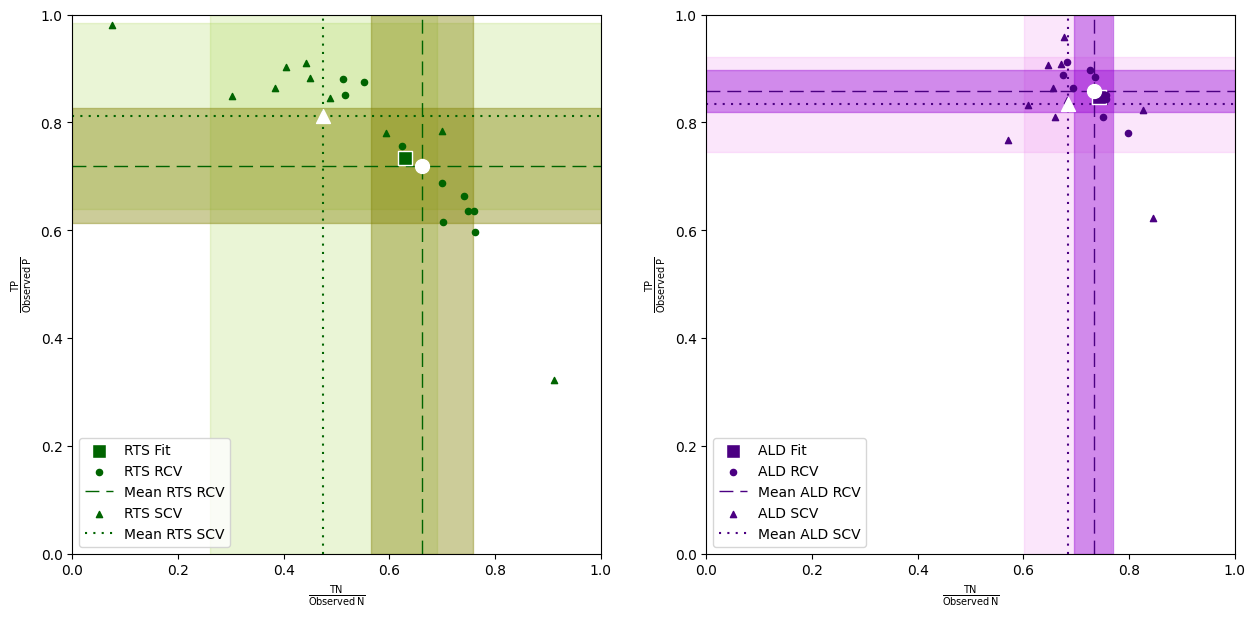

In [431]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.axvspan(np.mean(TN_obsN_scv_rts)+np.std(TN_obsN_scv_rts),
            np.mean(TN_obsN_scv_rts)-np.std(TN_obsN_scv_rts),
            alpha=0.2, color='yellowgreen', zorder=-3)
ax1.axhspan(np.mean(TP_obsP_scv_rts)+np.std(TP_obsP_scv_rts),
            np.mean(TP_obsP_scv_rts)-np.std(TP_obsP_scv_rts),
            alpha=0.2, color='yellowgreen', zorder=-3)

ax1.axvspan(np.mean(TN_obsN_rcv_rts)+np.std(TN_obsN_rcv_rts),
            np.mean(TN_obsN_rcv_rts)-np.std(TN_obsN_rcv_rts),
            alpha=0.4, color='olive', zorder=-2)
ax1.axhspan(np.mean(TP_obsP_rcv_rts)+np.std(TP_obsP_rcv_rts),
            np.mean(TP_obsP_rcv_rts)-np.std(TP_obsP_rcv_rts),
            alpha=0.4, color='olive', zorder=-2)

###############################################################################

ax1.scatter(TN_obsN_fit_rts, TP_obsP_fit_rts, s=100, c='darkgreen', marker="s", label='RTS Fit', edgecolor='w')
# ax1.axvline(x=TN_obsN_fit_rts, ymin=0, ymax=1, c='darkgreen', linewidth=1.5, zorder=-1, label='RTS Fit')
# ax1.axhline(y=TP_obsP_fit_rts, xmin=0, xmax=1, c='darkgreen', linewidth=1.5, zorder=-1)

ax1.scatter(TN_obsN_rcv_rts, TP_obsP_rcv_rts, s=20, c='darkgreen', marker="o", label='RTS RCV')
ax1.axvline(x=np.mean(TN_obsN_rcv_rts), ymin=0, ymax=1, c='darkgreen', linewidth=1, linestyle=(0, (10, 5)), zorder=-1)
ax1.axhline(y=np.mean(TP_obsP_rcv_rts), xmin=0, xmax=1, c='darkgreen', linewidth=1, linestyle=(0, (10, 5)), label='Mean RTS RCV', zorder=-1)
ax1.scatter(np.mean(TN_obsN_rcv_rts), np.mean(TP_obsP_rcv_rts), s=100, c='w', marker="o")

ax1.scatter(TN_obsN_scv_rts, TP_obsP_scv_rts, s=20, c='darkgreen', marker="^", label='RTS SCV')
ax1.axvline(x=np.mean(TN_obsN_scv_rts), ymin=0, ymax=1, c='darkgreen', linewidth=1.5, linestyle=(0, (1, 3)), zorder=-1)
ax1.axhline(y=np.mean(TP_obsP_scv_rts), xmin=0, xmax=1, c='darkgreen', linewidth=1.5, linestyle=(0, (1, 3)), label='Mean RTS SCV', zorder=-1)
ax1.scatter(np.mean(TN_obsN_scv_rts), np.mean(TP_obsP_scv_rts), s=100, c='w', marker="^")
###############################################################################

 # r"gamma: $\gamma$"
ax1.set_ylabel(r"$\frac{\rm TP}{Observed \, P}$")
ax1.set_xlabel(r"$\frac{\rm TN}{Observed \, N}$")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.legend()
# plt.savefig(folder_plot+'/Scatterplot_TP_TN.pdf', bbox_inches='tight')
# plt.show()
# fig = plt.figure(figsize=(8,8))
# ax1 = fig.add_subplot(111)

ax2.axvspan(np.mean(TN_obsN_scv_ald)+np.std(TN_obsN_scv_ald),
            np.mean(TN_obsN_scv_ald)-np.std(TN_obsN_scv_ald),
            alpha=0.2, color='violet', zorder=-3)
ax2.axhspan(np.mean(TP_obsP_scv_ald)+np.std(TP_obsP_scv_ald),
            np.mean(TP_obsP_scv_ald)-np.std(TP_obsP_scv_ald),
            alpha=0.2, color='violet', zorder=-3)

ax2.axvspan(np.mean(TN_obsN_rcv_ald)+np.std(TN_obsN_rcv_ald),
            np.mean(TN_obsN_rcv_ald)-np.std(TN_obsN_rcv_ald),
            alpha=0.4, color='darkviolet', zorder=-2)
ax2.axhspan(np.mean(TP_obsP_rcv_ald)+np.std(TP_obsP_rcv_ald),
            np.mean(TP_obsP_rcv_ald)-np.std(TP_obsP_rcv_ald),
            alpha=0.4, color='darkviolet', zorder=-2)

ax2.scatter(TN_obsN_fit_ald, TP_obsP_fit_ald, s=100, c='indigo', marker="s", label='ALD Fit', edgecolor='w')
# ax1.axvline(x=TN_obsN_fit_ald, ymin=0, ymax=1, c='indigo', linewidth=1.5, zorder=-1, label='ALD Fit')
# ax1.axhline(y=TP_obsP_fit_ald, xmin=0, xmax=1, c='indigo', linewidth=1.5, zorder=-1)

ax2.scatter(TN_obsN_rcv_ald, TP_obsP_rcv_ald, s=20, c='indigo', marker="o", label='ALD RCV')
ax2.axvline(x=np.mean(TN_obsN_rcv_ald), ymin=0, ymax=1, c='indigo', linewidth=1, linestyle=(0, (10, 5)), zorder=-1)
ax2.axhline(y=np.mean(TP_obsP_rcv_ald), xmin=0, xmax=1, c='indigo', linewidth=1, linestyle=(0, (10, 5)), label='Mean ALD RCV', zorder=-1)
ax2.scatter(np.mean(TN_obsN_rcv_ald), np.mean(TP_obsP_rcv_ald), s=100, c='w', marker="o")

ax2.scatter(TN_obsN_scv_ald, TP_obsP_scv_ald, s=20, c='indigo', marker="^", label='ALD SCV')
ax2.axvline(x=np.mean(TN_obsN_scv_ald), ymin=0, ymax=1, c='indigo', linewidth=1.5, linestyle=(0, (1, 3)), zorder=-1)
ax2.axhline(y=np.mean(TP_obsP_scv_ald), xmin=0, xmax=1, c='indigo', linewidth=1.5, linestyle=(0, (1, 3)), label='Mean ALD SCV', zorder=-1)
ax2.scatter(np.mean(TN_obsN_scv_ald), np.mean(TP_obsP_scv_ald), s=100, c='w', marker="^")

##

 # r"gamma: $\gamma$"
ax2.set_ylabel(r"$\frac{\rm TP}{Observed \, P}$")
ax2.set_xlabel(r"$\frac{\rm TN}{Observed \, N}$")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

ax2.legend()
plt.savefig(folder_plot+'/Scatterplot_TP_TN.pdf', bbox_inches='tight')
plt.show()


# Area test

In [149]:
hazard = 'ald'

## Dataset

In [126]:
filename_area_test2_geo = 'DataMat_area_test2.txt'
df_test2_geo = pd.read_csv(folder_original_data+'/'+filename_area_test2_geo,
                           header=0, sep="\t", quoting=csv.QUOTE_ALL)
# print(df.head())

In [127]:
columns_list = ["id", "X", "Y", "RTS", "ASP", "HC",
                "SLP", "VC", "ALB", "NDVI",
                "SNOWC", "TDD", "PRCP", "JT", "GROUP_NAME"]

In [128]:
df_test2_geo.columns = columns_list

In [129]:
df_test2_geo = df_test2_geo[["X", "Y", "GROUP_NAME"]]

In [130]:
filename_area_test2 = 'Area2_Final.txt'

In [131]:
df_test2 = pd.read_csv(folder_original_data+'/'+filename_area_test2,
                       header=0, sep='\t', quoting=csv.QUOTE_ALL)
# print(df.head())

In [132]:
columns_list = ["X", "Y", "ald", "rts", "ASP", "HC",
                "SLP", "VC", "ALB", "NDVI",
                "SNOWC", "TDD", "PRCP", "JT"]

In [133]:
df_test2.columns = columns_list

In [134]:
df_test2.dropna(inplace=True)

In [135]:
df_test2 = df_test2.merge(df_test2_geo, on=["X", "Y"])

### GEO category: string to number

In [136]:
df_test2['GEO'] = np.nan

In [137]:
geology_list = df_test2.GROUP_NAME.unique()

In [138]:
geology_list

array(['Hunt Fork Shale (Endicott Group)',
       'Beaucoup Formation, undivided',
       'Northern Alaska sedimentary rocks'], dtype=object)

In [139]:
for geology in geology_list:
    Ncode = list(df[df.GROUP_NAME == geology]['GEO'].unique())[0]
    print(Ncode)
    df_test2['GEO'][df_test2.GROUP_NAME == geology] = Ncode

10
2
24


In [140]:
df_test2['GEO'] = df_test2['GEO'].fillna(0)

## Test

In [150]:
if hazard == 'ald':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT',
               'ASP', 'TDD', 'SNOWC']
elif hazard == 'rts':
    GAM_sel = ['GEO', 'SLP', 'PRCP', 'NDVI', 'HC', 'ALB', 'VC', 'JT']
else:
    print('Wrong argument')

In [151]:
if hazard == 'rts':
    line_color = 'darkgreen'
    fill_color = 'yellowgreen'
else:
    line_color = 'indigo'
    fill_color = 'violet'

In [152]:
X = df_test2[GAM_sel].to_numpy()
y = df_test2[hazard].to_numpy()

In [153]:
gam_filename = folder_models+'/Final_training_gam_'+hazard+'.pkl'
with open(gam_filename, 'rb') as filez:
    gam = pickle.load(filez)

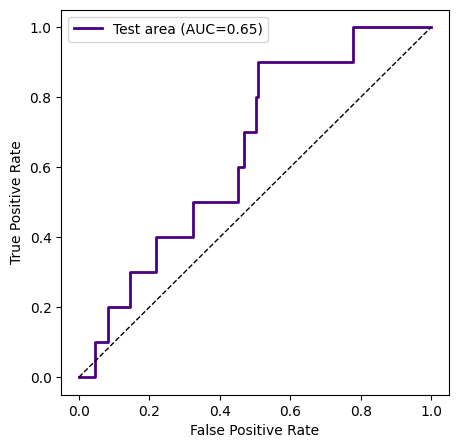

In [154]:
fig, ax = plt.subplots(figsize=(5, 5))
prob = gam.predict_proba(X)
prob_median = median(prob)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, prob)
auc = sklearn.metrics.roc_auc_score(y, prob)
ax.plot(fpr, tpr, color=line_color, linewidth=2,
        label=f'Test area (AUC={round(auc, 2)})')
ax.plot([0, 1], [0, 1],  linestyle="--", linewidth=1, color='k')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.savefig(folder_plot+'/ROC_test_area_'+hazard+'.pdf', bbox_inches='tight')
plt.show()

In [147]:
prob_median = median(prob)
suscept = prob

## Raster susceptibility

In [240]:
df_suscept_continuous = df_test2[['X', 'Y']].copy()

In [241]:
df_suscept_continuous['suscept'] = prob

In [242]:
df_suscept_continuous[['X', 'Y', 'suscept']].to_csv(folder_results_4maps+'/Sushi__alaska_area_test2_'+hazard+'.txt',
                                                    sep=' ',
                                                    header=True,
                                                    index=False,
                                                    na_rep='NaN',
                                                    float_format='%.2f')

In [243]:
gdf = gpd.GeoDataFrame(df_suscept_continuous,
                       geometry=gpd.points_from_xy(df_test2.X, df_test2.Y))

In [244]:
gdf.set_crs('epsg:5070')

,X,Y,suscept,geometry
0,-2751862.5,5607112.5,0.002757,POINT (-2751862.500 5607112.500)
1,-2751637.5,5607112.5,0.000429,POINT (-2751637.500 5607112.500)
2,-2751412.5,5607112.5,0.000811,POINT (-2751412.500 5607112.500)
3,-2751187.5,5607112.5,0.001284,POINT (-2751187.500 5607112.500)
4,-2750962.5,5607112.5,0.000807,POINT (-2750962.500 5607112.500)
...,...,...,...,...
1127,-2750737.5,5613187.5,0.000000,POINT (-2750737.500 5613187.500)
1128,-2750512.5,5613187.5,0.000000,POINT (-2750512.500 5613187.500)
1129,-2750287.5,5613187.5,0.000000,POINT (-2750287.500 5613187.500)
1130,-2750062.5,5613187.5,0.000000,POINT (-2750062.500 5613187.500)


In [245]:
from geocube.api.core import make_geocube

In [246]:
out_grid = make_geocube(vector_data=gdf, measurements=["suscept"],
                        resolution=(-225, 225)) #for most crs negative comes first in resolution

In [247]:
out_grid["suscept"].rio.to_raster(folder_results_4maps+"/sushi_area_test2_"+hazard+".tif")